In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import VECM
from sklearn.metrics import mean_squared_error
from datetime import datetime as dt
import datetime

In [2]:
def read_data():
  # Load CSV into dataframe and format
  df = pd.read_csv('final_daily.csv')
  df['date']=pd.to_datetime(df['date'])
  df=df[df['date']<datetime.datetime(2023,1,1)]

  variable = ['price', 'demand', 'avg_temp']

  VAL_PERC = 0.30

  n_train = int(len(df[:-365]) * (1 - VAL_PERC))

  dataframe_train = df[variable][0:-365]
  train_df = dataframe_train.values.reshape(-1, 3)

  dataframe_test = df[variable][-365:]
  test_df = dataframe_test.values.reshape(-1, 3)

  dataframe_dataset = df[variable][0:df.shape[0]]
  dataset= dataframe_dataset.values.reshape(-1, 3)

  return df, train_df, test_df, dataset

In [3]:
df, train_df, val_df, dataset = read_data()

In [4]:
# # make prediction on validation
# start = dt.now()
# model = VAR(endog=train_df)
# model_fit = model.fit()
# prediction = model_fit.forecast(model_fit.endog, steps=1)
# running_secs = (dt.now() - start).microseconds
# print(running_secs)
# #prediction = np.array(prediction)

In [5]:
train_df.shape

(731, 3)

In [6]:
# make prediction on validation
prediction = []
history = list(train_df)
start = dt.now()
for i in range(len(val_df)):
  model = VAR(endog=history)
  model_fit = model.fit(maxlags=24, ic = 'aic')
  output = model_fit.forecast(model_fit.endog, steps=1)
  yhat = output[0]
  prediction.append(yhat)
  obs = val_df[i]
  history.append(obs)
running_secs = (dt.now() - start).microseconds
print(running_secs)
prediction = np.array(prediction)

835000


In [7]:
print(running_secs * (1e-6))

0.835


In [8]:
prediction

array([[3.03873502e+01, 3.60908992e+05, 5.43996830e+00],
       [2.30690218e+01, 3.59533353e+05, 4.80919047e+00],
       [3.06477322e+01, 3.99821453e+05, 3.86642687e+00],
       ...,
       [5.23455678e+01, 3.86498088e+05, 4.29379678e+00],
       [3.19458708e+01, 3.61967331e+05, 4.33590100e+00],
       [3.09719545e+01, 3.52857247e+05, 5.12751994e+00]])

In [9]:
#converting predictions to dataframe
pred = pd.DataFrame(index=range(0,len(prediction)),columns=range(3))
for j in range(0,3):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

#check rmse
print('rmse is : ', np.sqrt(mean_squared_error(pred, val_df)))

rmse is :  10614.541232255247


In [10]:
seq_size = 1

def plotting (dataset, trainPredict, valPredict):
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[seq_size-1:len(trainPredict)+seq_size-1, :] = trainPredict

    # shift val predictions for plotting
    valPredictPlot = np.empty_like(dataset)
    valPredictPlot[:, :] = np.nan
    valPredictPlot[len(trainPredict)+(seq_size*2)-2:, :] = valPredict

    # plot baseline and predictions
    mpl.rcParams['figure.dpi'] = 300
    plt.plot(dataset, color='k', label='dataset')
    plt.plot(trainPredictPlot, color='b', label='train', linestyle='dashed')
    plt.plot(valPredictPlot, color='g', label='Val', linestyle='dashed')
    plt.legend(loc="upper left")
    plt.title("Prediction")
    plt.xlabel("Time")
    plt.ylabel("Count")
    plt.show()

    return

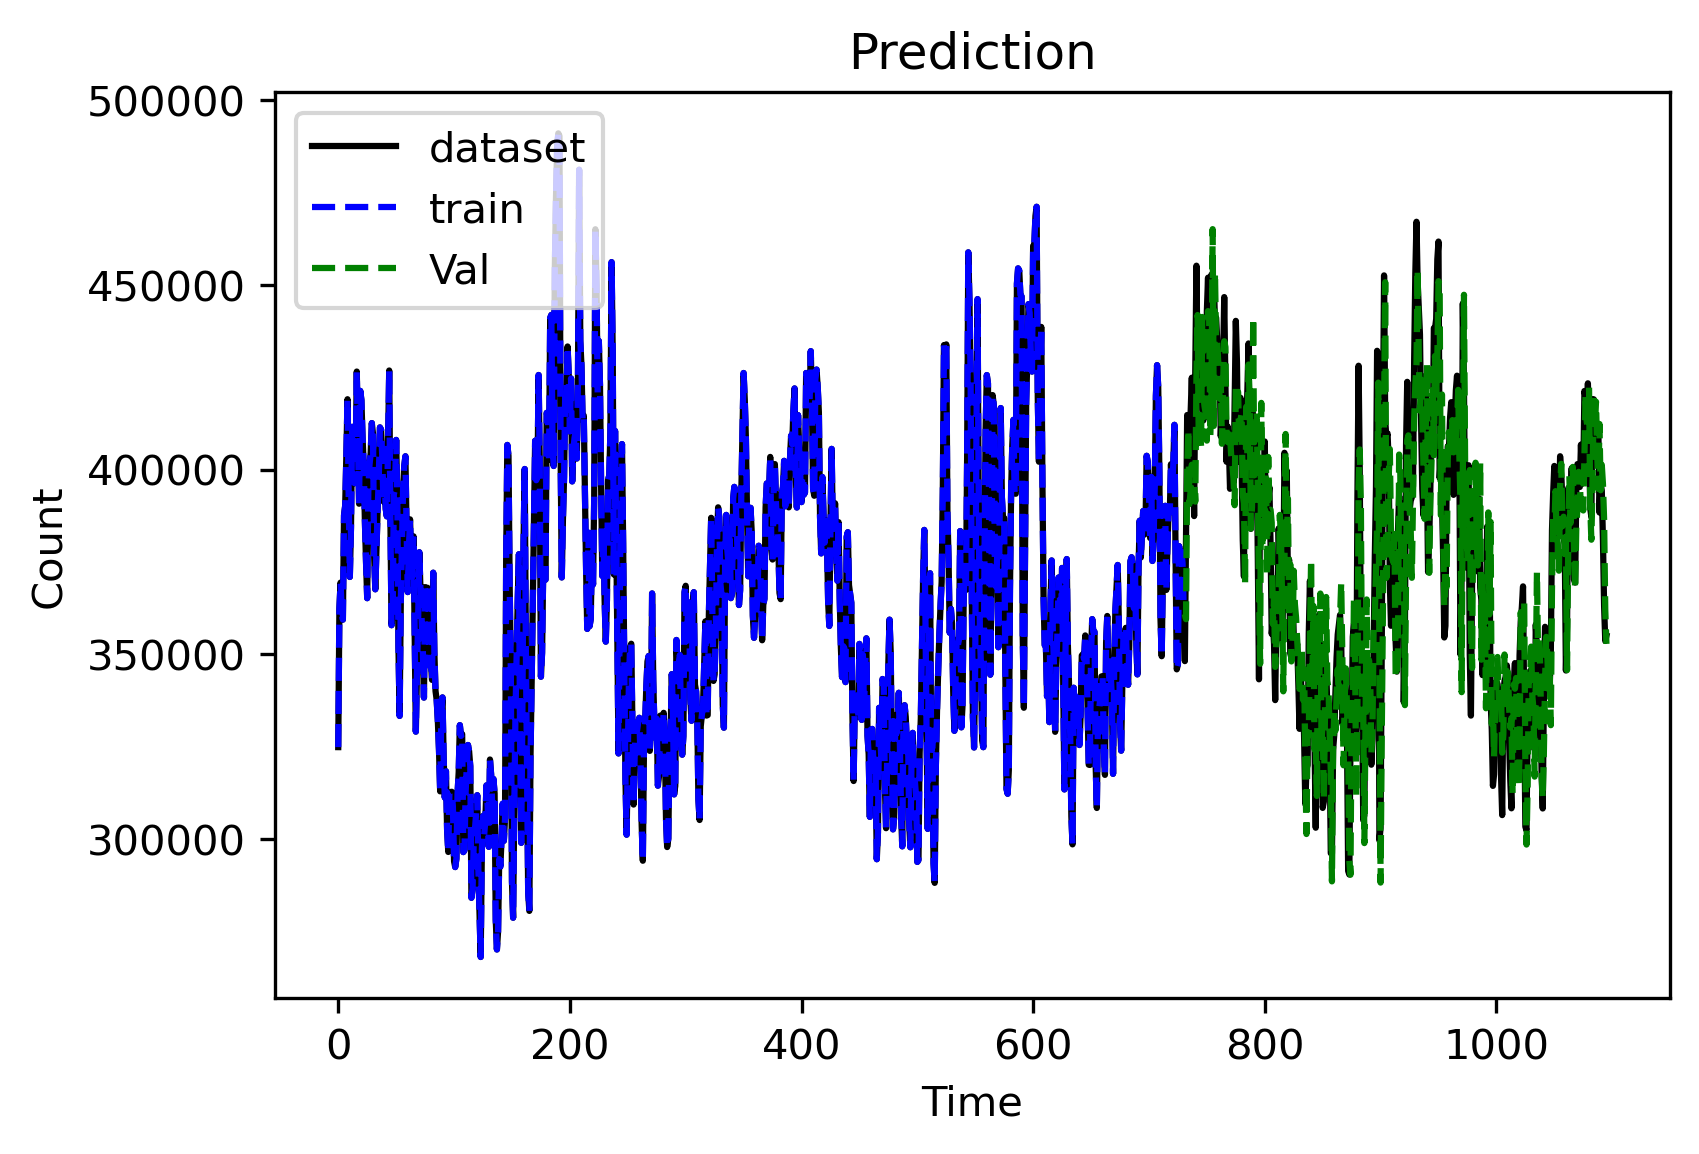

In [11]:
plotting (dataset[:, 1].reshape(-1, 1), train_df[:, 1].reshape(-1, 1), prediction[:, 1].reshape(-1, 1))

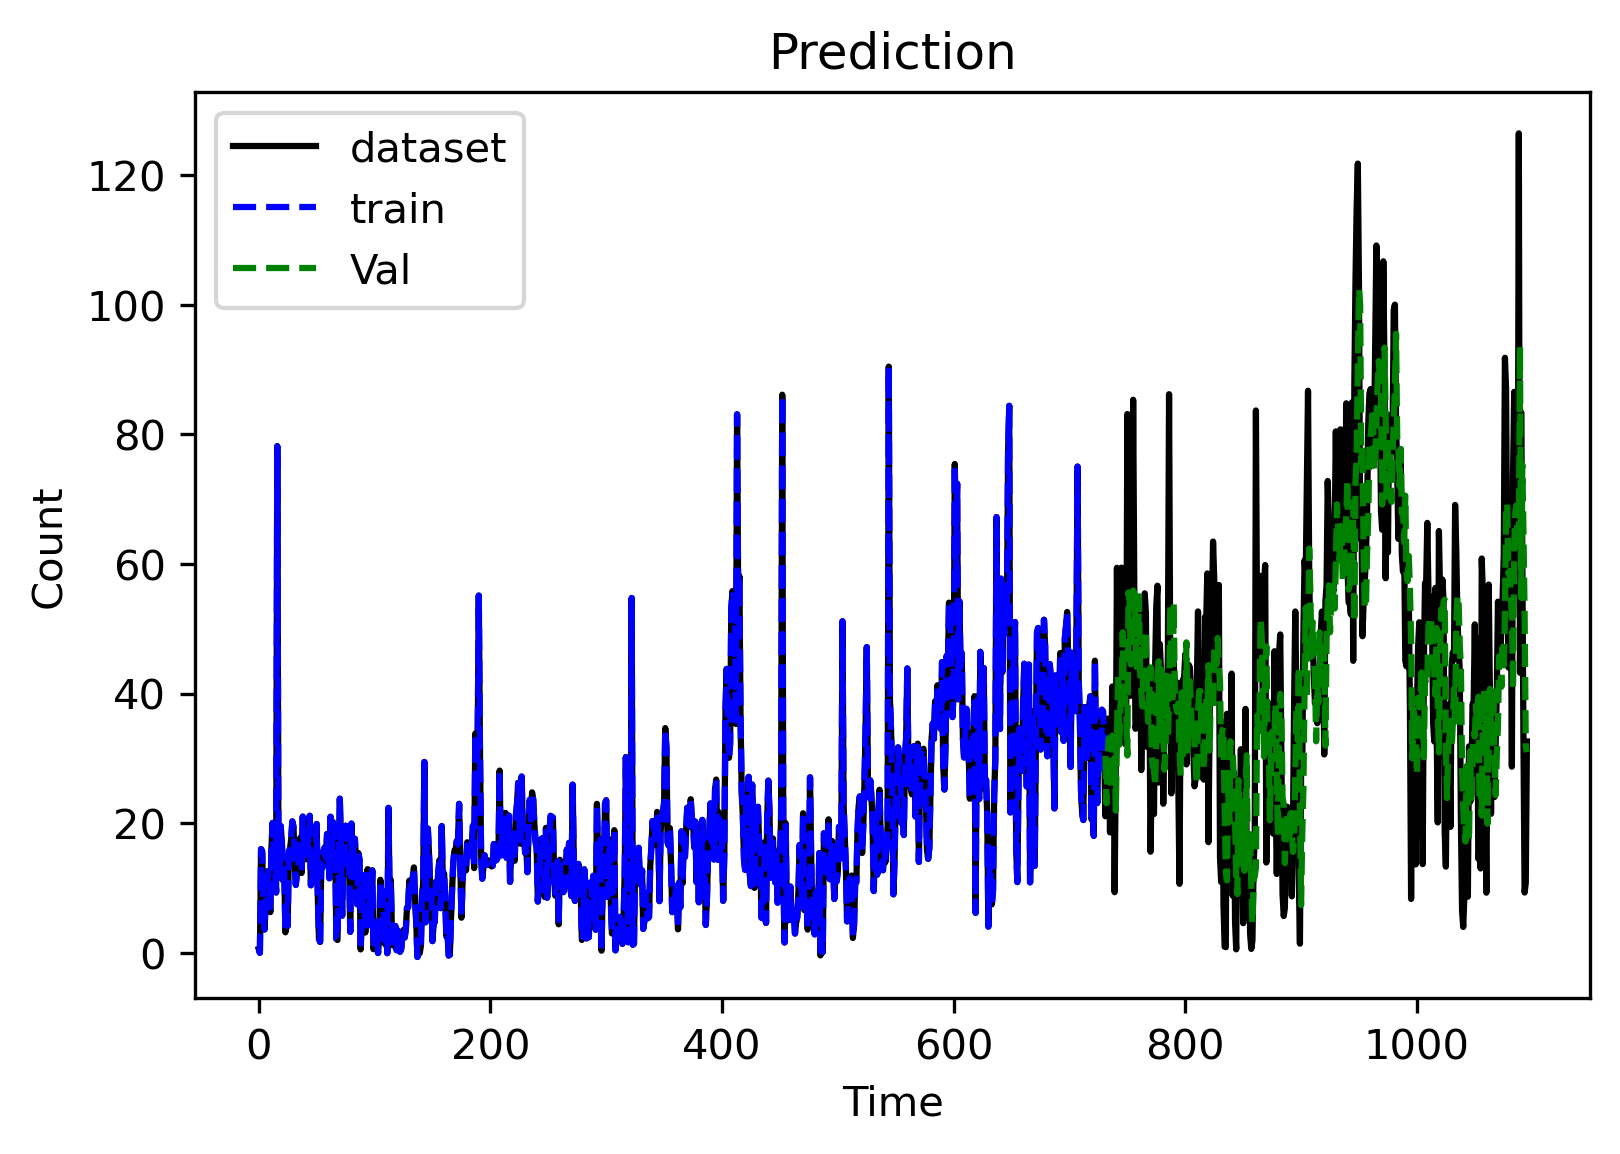

In [12]:
plotting (dataset[:, 0].reshape(-1, 1), train_df[:, 0].reshape(-1, 1), prediction[:, 0].reshape(-1, 1))

In [13]:
np.square(val_df[:, 0] - prediction[:, 0].reshape(-1, 1)).mean()

900.0812146846905

In [14]:
np.abs(val_df[:, 0] - prediction[:, 0].reshape(-1, 1)).mean()

23.688494193535767

In [15]:
def mape(x, y):
  error = abs(x-y)/abs(x)
  error[error > 1] = 1
  return np.mean(error)

mape(val_df[:, 0], prediction[:, 0].reshape(-1, 1)[:, 0])

0.32629816413169305

In [16]:
np.square(val_df[:, 1] - prediction[:, 1].reshape(-1, 1)).mean()

2731249078.2024446

In [17]:
np.abs(val_df[:, 1] - prediction[:, 1].reshape(-1, 1)).mean()

42321.846468101474

In [18]:
def mape(x, y):
  error = abs(x-y)/abs(x)
  error[error > 1] = 1
  return np.mean(error)

mape(val_df[:, 1], prediction[:, 1].reshape(-1, 1)[:, 0])

0.038502978785358785